## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Нам предстоит решить задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке. 

Представим себе, что мы заказываем такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько мы должны будем за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее. 

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф. 
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта мы отработаем навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection

Прочитаем наш файл с исходными данными:

In [3]:
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Условно разделим признаки на несколько групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 

### 2.1 Признак pickup_datetime
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда

Определим временные рамки, за которые представлены данные.

In [4]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
print('Временные рамки:', taxi_data['pickup_datetime'].dt.date.min(), taxi_data['pickup_datetime'].dt.date.max())

Временные рамки: 2016-01-01 2016-06-30


### 2.2 Работа с пропусками
Посмотрим на пропуски:

In [5]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Нам повезло, в данных отсутствуют пропуски.

### 2.3 Cтатистические характеристики
Посмотрим на статистические характеристики признаков.


In [6]:
taxi_data.describe(include='all')

/var/folders/xx/g9ddp_l94kn2b3bnr9fpjm3w0000gn/T/ipykernel_47428/2726144569.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data.describe(include='all')
/var/folders/xx/g9ddp_l94kn2b3bnr9fpjm3w0000gn/T/ipykernel_47428/2726144569.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  taxi_data.describe(include='all')


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2875421,NaN,2016-03-04 08:07:34,2016-02-19 19:25:04,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
first,NaN,NaN,2016-01-01 00:00:17,2016-01-01 00:03:31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,2016-07-01 23:02:03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02


Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


### 2.4 Функция add_datetime_features()
Реализуем функцию, которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [7]:
def add_datetime_features(df):
    
    """ Функция, которая принимает на вход таблицу с данными о поездках 
    (DataFrame) и возвращает ту же таблицу с
    добавленными в нее новыми столбцами"""
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    
    return df



taxi_data = add_datetime_features(taxi_data)

In [8]:
#Псмотрим на распределение поездок по дням недели
taxi_data['pickup_day_of_week'].value_counts()

Friday       223533
Saturday     220868
Thursday     218574
Wednesday    210136
Tuesday      202749
Sunday       195366
Monday       187418
Name: pickup_day_of_week, dtype: int64

In [9]:
#Посмотрим, сколько поездок в среднем совершается за день
taxi_data['pickup_date'].value_counts().mean()

8014.527472527472

### 2.5 Функция add_holiday_features()
Добавим в наш датасет информацию о том, является ли день праздничным. Для этого загрузим данные обо всех праздничных днях в Америке за 2016 год. Данные представлены в табличном формате CSV и содержат три столбца:

1. day — день недели;
2. date — дата;
3. holiday — наименование праздника.


In [10]:
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date']).dt.date
holiday_data_list = list(holiday_data['date'])



Реализуем функцию add_holiday_features(), которая принимает на вход две таблицы: 

* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). 

In [11]:
def add_holiday_features(df, holiday_data):
    
    """Функция принимает на вход данные из таблиц о поездках и праздничных
    днях и добавляет в таблицу о поездках бинарный признак совершения/несовершения начала
    поездки в праздничный день"""
    
    holiday_data_list = list(holiday_data['date'])
    df['pickup_holiday'] = df['pickup_date'].apply(lambda x: 1 if x in holiday_data_list else 0)
    
    return df


taxi_data = add_holiday_features(taxi_data, holiday_data)

### 2.6 Функция add_osrm_features()

Мы разобрались с временными характеристиками, переходим к географическим.

В данных есть столбцы, содержащие информацию о широте и долготе. Из них можно извлечь очень много полезной информации. Загрузим данные из OSRM API для каждой поездки из тренировочной и тестовой выборок нашего набора данных. Нас будут интересовать только следующие столбцы:


1. id — идентификатор поездки;
2. total_distance — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
3. total_travel_time — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, до точки, в которой счётчик был выключен (согласно OSRM);
4. number_of_steps — количество дискретных шагов, которые должен выполнить водитель (поворот налево/поворот направо/ехать прямо и т. д.).

In [12]:
osrm_data = pd.read_csv('data/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:

* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [13]:
def add_osrm_features(df, osrm_data):
    
    """Функция принимает на вход таблицы с данными и поездках и данными из OSRM и возвращает
    таблицу с данными с добавлением новых географических признаков"""
    
    osrm_data = osrm_data[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    taxi_data = pd.merge(df, osrm_data, on = 'id', how = 'left')
    return taxi_data


taxi_data = add_osrm_features(taxi_data, osrm_data)

В результате объединения таблиц у нас получились пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника. 

In [14]:
#Посмотрим, сколько строк содержат пропуски после объединения таблиц
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

Создадим две функции:

* get_haversine_distance — функция для вычисления расстояния по формуле гаверсинуса (в километрах);
* get_angle_direction — функция для вычисления угла направления движения (в градусах).

In [15]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    
    """ функция для вычисления расстояния по формуле гаверсинуса (в километрах)"""
    
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371 
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    
    """Функция для вычисления расстояния по формуле гаверсинуса (в километрах)"""
    
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### 2.7 Функция add_geographical_features()
Реализуем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.


In [16]:
def add_geographical_features(df):
    
    """Функция добавляет в данных о поездках данные о расстоянии Хаверсина
    и направление движения точки"""
    
    df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_angle_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    
    return df


taxi_data = add_geographical_features(taxi_data)

###  2.8 Функция add_cluster_features()
Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.


In [17]:
# создаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))
# обучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=10, random_state=42)

In [18]:
def add_cluster_features(df, kmeans):
    
    """Функция должна возвращать обновлённую таблицу с данными о поздеках с добавленным 
    в неё столбцом географического кластера, к которому относится поездка"""
    
    df['geo_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude','dropoff_latitude', 'dropoff_longitude']])
    
    return df


taxi_data = add_cluster_features(taxi_data, kmeans)

# распределение географических кластеров:
taxi_data['geo_cluster'].value_counts()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


0    596467
9    383874
4    359233
5     43619
7     41171
3     27022
1      7233
6        18
8         5
2         2
Name: geo_cluster, dtype: int64

### 2.9 Функция add_weather_features()

Загрузим набор данных, содержащий информацию о погодных условиях в Нью-Йорке в 2016 году. Датасет представлен в табличном формате CSV. Нас будут интересовать только следующие столбцы:

* time — дата измерения (с интервалом в час);
* temperature — температура;
* visibility — видимость;
* wind speed — средняя скорость ветра;
* precip — количество осадков;
* events — погодные явления: Rain — дождь, Snow — снег, Fog — туман, None — отсутствие погодных явлений.

In [19]:
weather_data = pd.read_csv('data/weather_data.csv')
weather_data['time'] = pd.to_datetime(weather_data['time'])
weather_data['date'] = weather_data['time'].dt.date
weather_data['hour'] = weather_data['time'].dt.hour

Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки. 

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.

In [20]:
def add_weather_features(df, weather_data):
    
    """Функция добавляет в данные о поездках информацию о погодных условия"""
    
    weather_data = weather_data[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
    df = df.merge(weather_data, how = 'left', left_on = ['pickup_date', 'pickup_hour'], right_on = ['date', 'hour'])
    
    return df


taxi_data = add_weather_features(taxi_data, weather_data)
taxi_data = taxi_data.drop(['date', 'hour'], axis = 1)
#taxi_data.head()

В результате объединения получились записи, для которых в столбцах temperature, visibility, wind speed, precip и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счётчик поездки.

In [21]:
taxi_data['visibility'].isnull().mean()

0.008248757064780714

### 2.10 Функция fill_null_weather_data()
Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируем данные по столбцу pickup_date и рассчитаем медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполним пропуски. 
Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана). 

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам. 



In [22]:
def fill_null_weather_data(df):
    
    """"Функция заполняет пропуски в столбцах о погоде"""
    
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    df[col] = df[col].fillna(
    df.groupby('pickup_date')[col].transform('median')
    )
    df['events'] = df['events'].fillna('None')
    osrm_col = ['total_distance', 'total_travel_time', 'number_of_steps']
    df[osrm_col] = df[osrm_col].fillna(df[osrm_col].median())
    
    return df


taxi_data = fill_null_weather_data(taxi_data)
taxi_data.isnull().sum()# проверим, что пропусков не осталось

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу.

Будем пользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом: 
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


Text(0.5, 1.0, 'Диаграмма рассеяния средней скорости движения автомобилей')

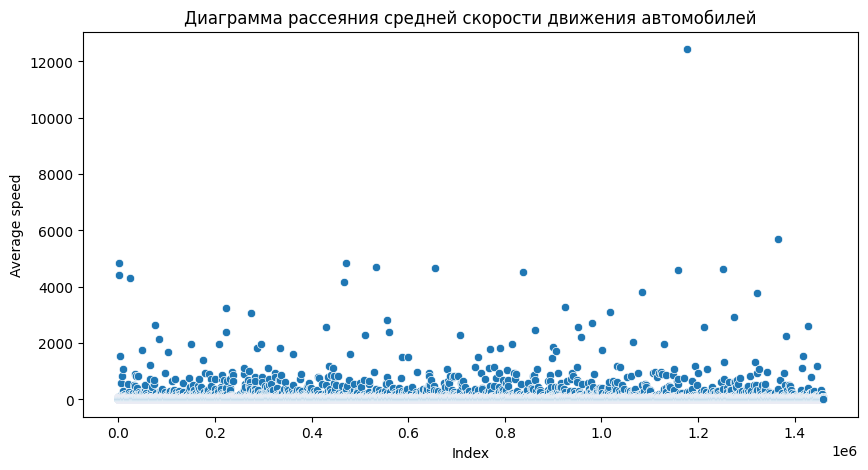

In [23]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed')
ax.set_title('Диаграмма рассеяния средней скорости движения автомобилей')

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч. 


### 2.11 Работа с выбросами
Найдем поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

Найдем поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных. 


In [24]:
taxi_data[taxi_data['trip_duration'] > 24*60*60]['trip_duration'].count()

4

In [25]:
row_index = taxi_data[taxi_data['trip_duration'] > 24*60*60]['trip_duration'].index
taxi_data = taxi_data.drop(labels=row_index, axis = 0)

In [26]:
taxi_data[(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300]['id'].count()

407

In [27]:
row_index = taxi_data[(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6) > 300]['id'].index
taxi_data = taxi_data.drop(labels=row_index, axis = 0)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта сделаем следующее:
* Исследуем сформированный набор данных; 
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [28]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)

### 3.1 Исследование целевого признака на нормальность
Построим гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log). 

<AxesSubplot: xlabel='trip_duration_log'>

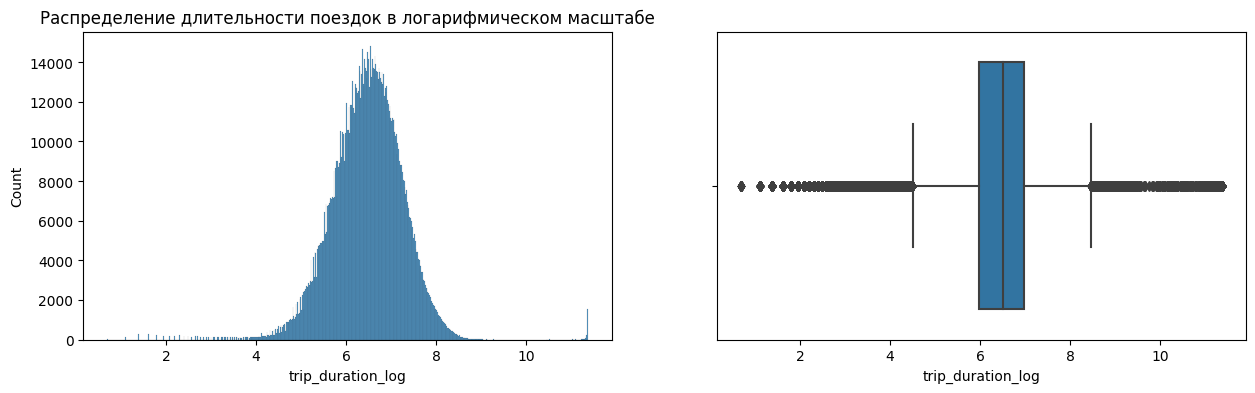

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig1 = sns.histplot(data = taxi_data,
             x = 'trip_duration_log', ax=axes[0])
fig1.set_title('Распределение длительности поездок в логарифмическом масштабе')
sns.boxplot(data = taxi_data,
             x = 'trip_duration_log', ax=axes[1])

Проверим является ли полученное распределение нормальным с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$. 

In [30]:
from scipy.stats import normaltest

alpha = 0.05 #уровень значимости

H0 = 'Данные распределены нормально'
Ha = 'Данные не распределены нормально (мы отвергаем H0)'

_, p = normaltest(taxi_data['trip_duration_log'])
#normaltest возвращает двустороннюю вероятность для проверки гипотезы

print('p=%.3f' % p)

# Интерпретация 

if p > alpha/2:
	print(H0)
else:
	print(Ha)

p=0.000
Данные не распределены нормально (мы отвергаем H0)


### 3.2 Исследование зависимости целевого признака от таксопарка
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id). 

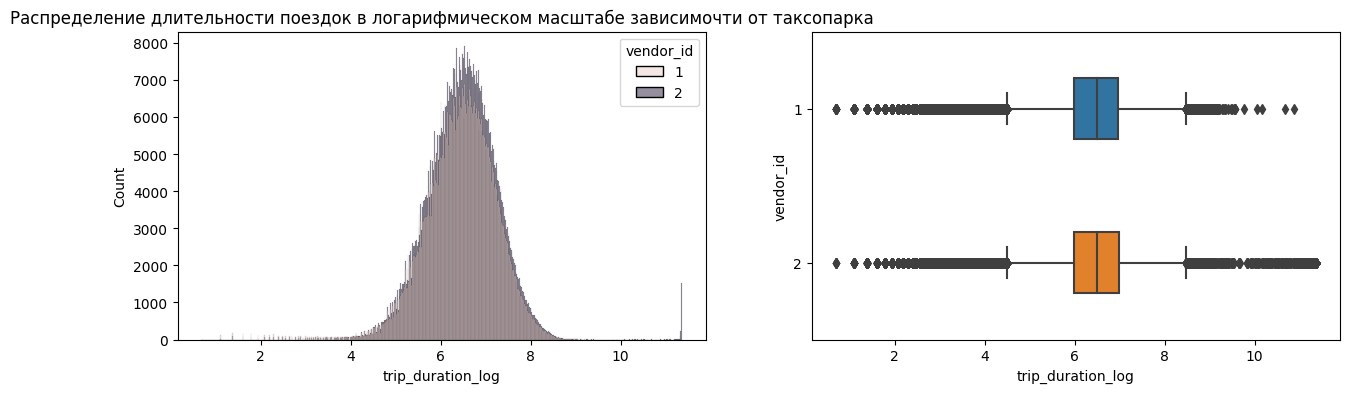

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig = sns.histplot(data = taxi_data, x = 'trip_duration_log', hue='vendor_id', ax=axes[0])
fig.set_title('Распределение длительности поездок в логарифмическом масштабе зависимочти от таксопарка')
boxplot = sns.boxplot(
    data=taxi_data,
    y='vendor_id',
    x='trip_duration_log',
    orient='h',
    width=0.4,
    ax=axes[1]
)

*Как видим из визуализации, распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки*

### 3.3 Исследование зависимости целевого признака от признака отправки сообщения поставщику
Построим визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag). 

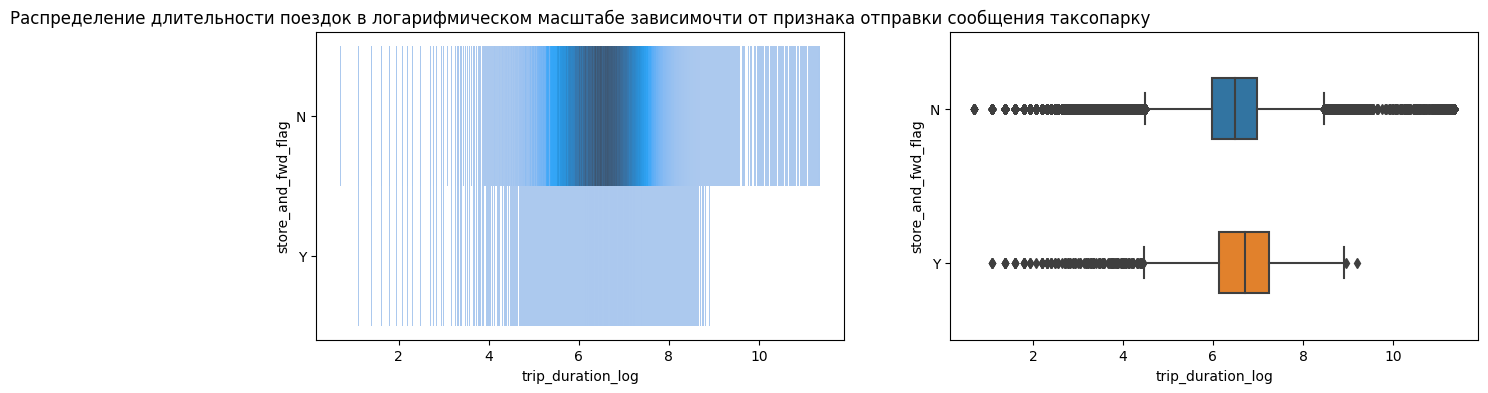

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
fig = sns.histplot(data = taxi_data, x = 'trip_duration_log', y='store_and_fwd_flag', ax=axes[0])
fig.set_title('Распределение длительности поездок в логарифмическом масштабе зависимочти от признака отправки сообщения таксопарку')
boxplot = sns.boxplot(
    data=taxi_data,
    y='store_and_fwd_flag',
    x='trip_duration_log',
    orient='h',
    width=0.4,
    ax=axes[1]
)

*Из графиков видно, что распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.*

### 3.4 
Построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

Text(0.5, 1.0, 'Распределение количества поездок в зависимости от часа дня')

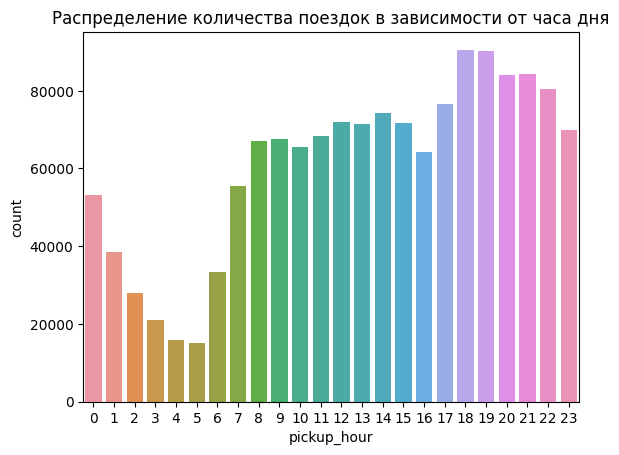

In [33]:
countplot = sns.countplot(
    data=taxi_data,
    x='pickup_hour',
)
countplot.set_title('Распределение количества поездок в зависимости от часа дня')

Text(0.5, 1.0, 'зависимость медианной длительности поездки от времени поездки')

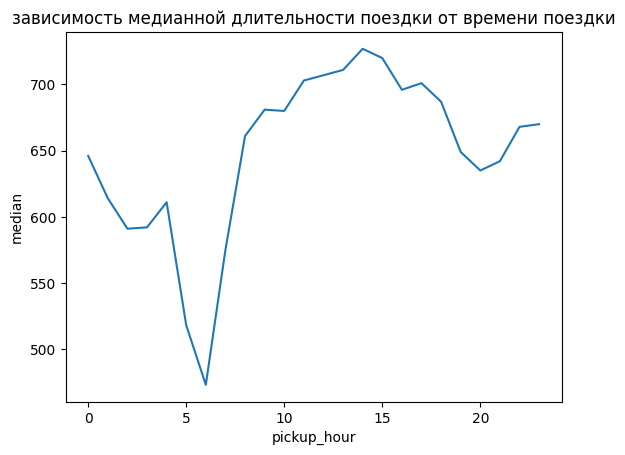

In [34]:
grouped_data = taxi_data.groupby(by = 'pickup_hour' )['trip_duration'].agg(['median']).reset_index()
fig = sns.lineplot(data = grouped_data,
             x = 'pickup_hour',
             y = 'median',)
fig.set_title('зависимость медианной длительности поездки от времени поездки')

*Из графиков, что реже всего такси заказывают ночью(с 00:00 по 5:00), пик спроса приходится на вчеренее время (с 17:00 по 22:00).*
*Самые длительные поездки приходятся на промежуток времени с 8:00 по 18:00 (более 650 секунд), самые короткие по времени приходятся на 6:00 утра (менее 500 секунд)*

### 3.5.
Построим две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

Text(0.5, 1.0, 'Распределение количества поездок в зависимости от дня недели')

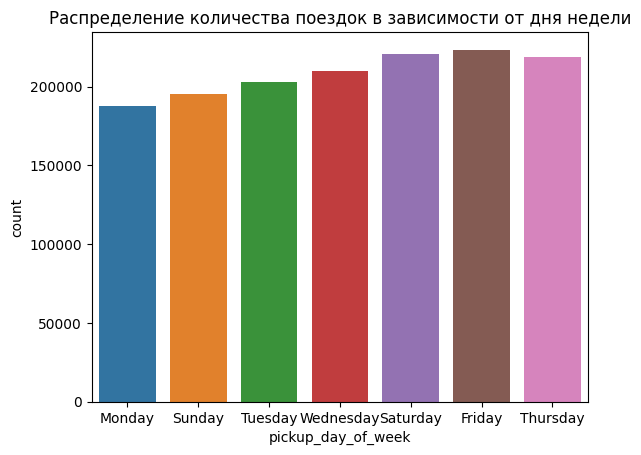

In [35]:
countplot = sns.countplot(
    data=taxi_data,
    x='pickup_day_of_week',
)
countplot.set_title('Распределение количества поездок в зависимости от дня недели')

Text(0.5, 1.0, 'зависимость медианной длительности поездки от дня недели')

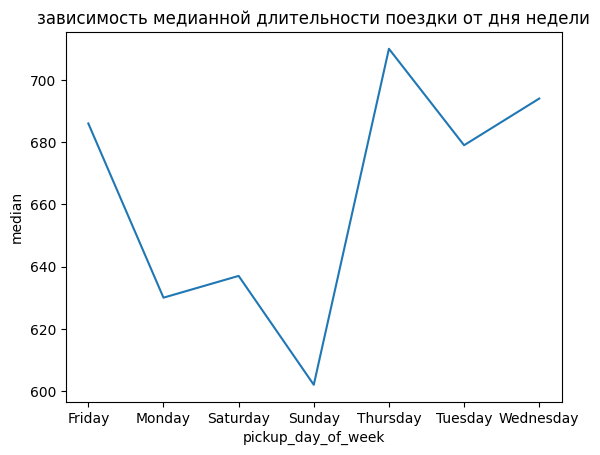

In [36]:
grouped_data = taxi_data.groupby(by = 'pickup_day_of_week' )['trip_duration'].agg(['median']).reset_index()
fig = sns.lineplot(data = grouped_data,
             x = 'pickup_day_of_week',
             y = 'median',)
fig.set_title('зависимость медианной длительности поездки от дня недели')

*Из графиков видно, что меньше всего такси пользуется спросом по понедельникам, а чаще всего по пятницам*

*Самые короткие по длительности поездки приходятся на воскресенье (чуть больше 600 секунд в медианном значении), а самые длительные поездки совершаются по четвергам (более 700 секунд)*

### 3.6 Исследование целевого признака от дня недели и времени отправления
Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration). 

Визуализируем полученную сводную таблицу с помощью тепловой карты.

Text(0.5, 1.0, 'Зависимость длительности поездки от дня недели и времени отправления')

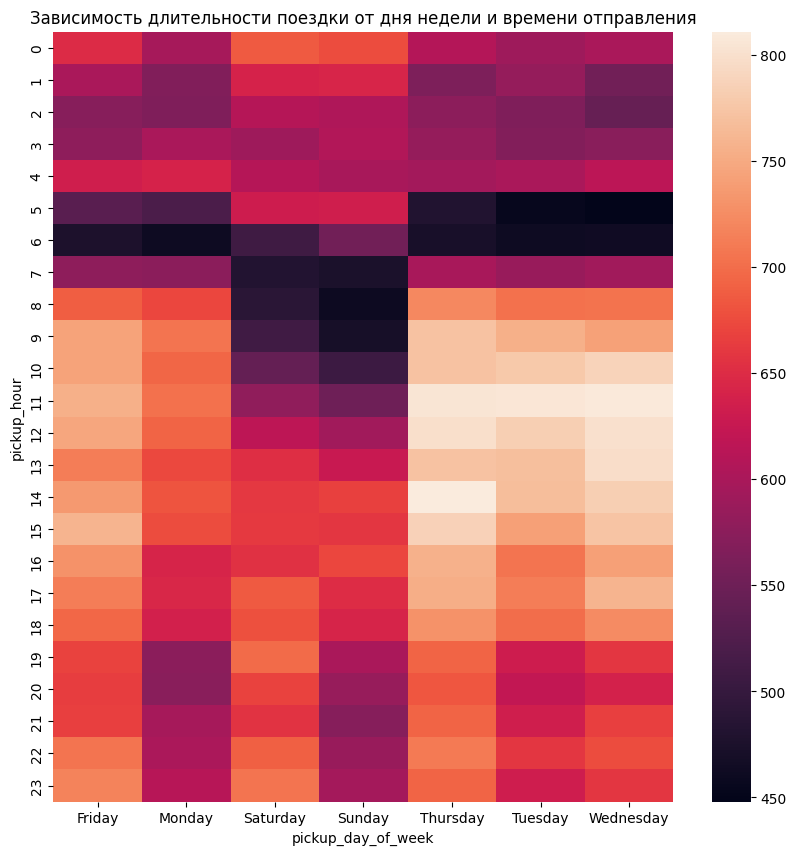

In [37]:
pivot = pd.pivot_table(taxi_data, index=['pickup_hour'], columns = 'pickup_day_of_week', values = 'trip_duration', aggfunc='median')
fig = plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(pivot)
heatmap.set_title('Зависимость длительности поездки от дня недели и времени отправления')

### 3.7.
Построим две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude) 
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложим широту (longitude), а по оси ординат - долготу (latitude). 
Включим в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавим следующие ограничения на границы осей абсцисс и ординат:
 
city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавим на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее. 

Text(0.5, 1.0, 'Географическое расположение точек начала поездок в зависимости от кластера')

/Users/daniilbalkhin/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/daniilbalkhin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


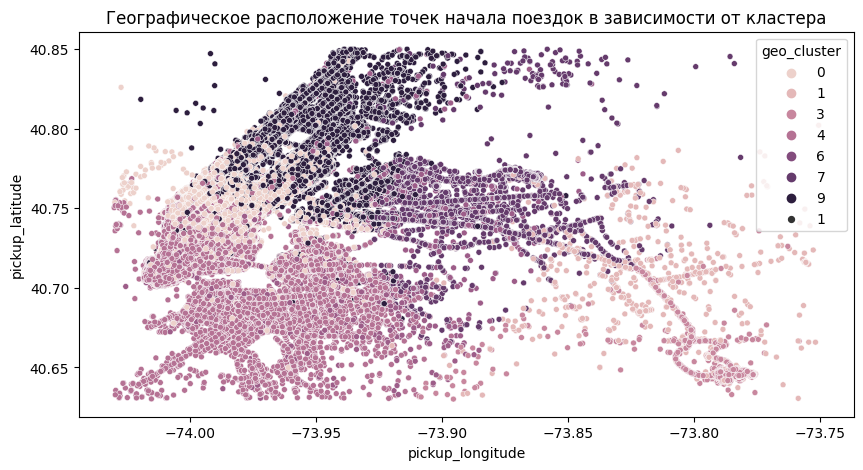

In [38]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
New_Yourk_geo = (taxi_data['pickup_longitude'] > -74.03) & (taxi_data['pickup_longitude'] < -73.75) & (taxi_data['pickup_latitude'] > 40.63) & (taxi_data['pickup_latitude'] < 40.85)
scatter_data = taxi_data[New_Yourk_geo]
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = scatter_data,
                x='pickup_longitude', y='pickup_latitude', hue = 'geo_cluster', size = 1, ax=ax)
ax.set_xlabel('pickup_longitude')
ax.set_ylabel('pickup_latitude')
ax.set_title('Географическое расположение точек начала поездок в зависимости от кластера')

Text(0.5, 1.0, 'Географическое расположение точек завершения поездок в зависимости от кластера')

/Users/daniilbalkhin/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/daniilbalkhin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


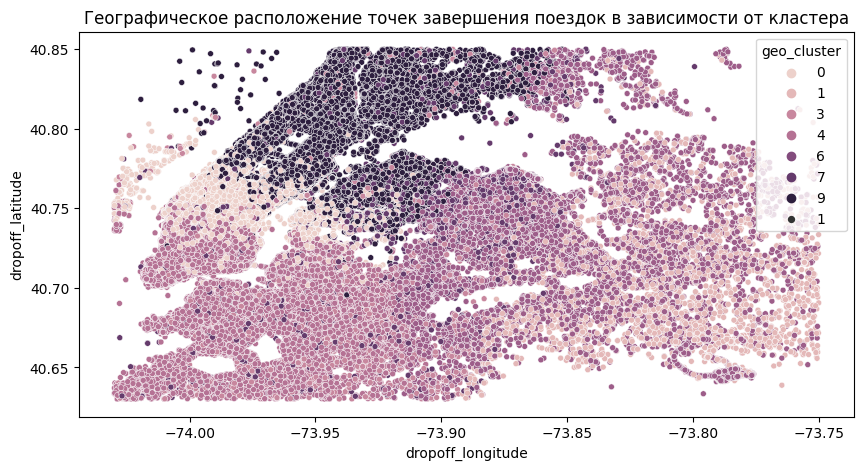

In [39]:
New_Yourk_geo = (taxi_data['dropoff_longitude'] > -74.03) & (taxi_data['dropoff_longitude'] < -73.75) & (taxi_data['dropoff_latitude'] > 40.63) & (taxi_data['dropoff_latitude'] < 40.85)
scatter_data = taxi_data[New_Yourk_geo]
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = scatter_data,
                x='dropoff_longitude', y='dropoff_latitude', hue = 'geo_cluster', size = 1, ax=ax)
ax.set_xlabel('dropoff_longitude')
ax.set_ylabel('dropoff_latitude')
ax.set_title('Географическое расположение точек завершения поездок в зависимости от кластера')

*Из диаграммы видно, что 2 кластера (из десяти) не попало на диаграммы, то есть они находятся за границами Нью-Йорка.*

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, сделаем ещё несколько шагов.
* Т.к. многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде, необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [40]:
print('Shape of data: {}'.format(taxi_data.shape))
print('Columns: {}'.format(taxi_data.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [41]:
train_data = taxi_data.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None,6.077642


### 4.1 Удаление неинформативных и избыточных признаков
Удалим следующие признаки:

а) *id*, тк он является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности

б) *dropoff_datetime*, который создает утечку данных. *dropoff_datetime* - зафиксированное время остановки счётчика. Начиная поездку, мы никак не можем точно знать, когда она закончится, ведь мы как раз и пытаемся предсказать время окончания поездки.

в) *pickup_datetime, pickup_date*, тк мы извлекли всю необходимую для нас информацию из даты начала поездки


In [42]:
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### 4.2 Кодирование бинарных признаков

Закодируем признак vendor_id в таблице train_data таким образом, чтобы он был равен 0, если идентификатор таксопарка равен 1, и 1 — в противном случае.

Закодируем признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение 'N', и 1 — в противном случае.


In [43]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

### 4.3 Однократное кодирование
Закодируем признаки pickup_day_of_week, geo_cluster и events однократным кодированием  с помощью OneHotEncoder из библиотеки sklearn:

In [44]:
from sklearn.preprocessing import OneHotEncoder
 
one_hot_encoder = OneHotEncoder(drop='first')
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(train_data[columns_to_change]).toarray() 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
data_onehot.shape

(1458233, 18)

Добавим полученную таблицу с закодированными признаками:

In [45]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot], 
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [46]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [47]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### 4.4. Отбор значимых признаков
С помощью SelectKBest отберем 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуем по обучающей выборке.


In [48]:
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)
 
best_features = selector.get_feature_names_out()

In [49]:
X_train_kbest = X_train[best_features]
X_valid_kbest = X_valid[best_features]

### 4.5 Нормализация данных
Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.
Нормализуем предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn


In [50]:
from sklearn.preprocessing  import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_kbest)

X_train_kbest_scaled = scaler.transform(X_train_kbest)
X_valid_kbest_scaled = scaler.transform(X_valid_kbest)
X_train_kbest_scaled = pd.DataFrame(X_train_kbest_scaled, columns=best_features)
X_valid_kbest_scaled = pd.DataFrame(X_valid_kbest_scaled, columns=best_features)

In [51]:
#посмотрим на результат нормализации
X_valid_kbest_scaled.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,pickup_holiday,total_distance,...,pickup_day_of_week_Saturday,pickup_day_of_week_Sunday,pickup_day_of_week_Thursday,pickup_day_of_week_Tuesday,pickup_day_of_week_Wednesday,geo_cluster_1,geo_cluster_3,geo_cluster_5,geo_cluster_7,geo_cluster_9
count,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,...,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000,481217.000000
mean,0.535434,0.238098,0.791444,0.638333,0.791445,0.730622,0.005474,0.591668,0.035259,0.052578,...,0.151678,0.133786,0.150360,0.139029,0.144037,0.005046,0.018603,0.029935,0.028143,0.262667
std,0.498743,0.188054,0.001342,0.003056,0.001342,0.002972,0.073781,0.278115,0.184433,0.060203,...,0.358709,0.340422,0.357425,0.345977,0.351127,0.070853,0.135118,0.170407,0.165382,0.440084
min,0.000000,0.000000,-0.000002,0.094945,-0.000002,0.255093,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.142857,0.791142,0.636977,0.791150,0.729263,0.000000,0.391304,0.000000,0.018952,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.142857,0.791308,0.638649,0.791341,0.730850,0.000000,0.608696,0.000000,0.031313,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.285714,0.791547,0.640078,0.791617,0.732153,0.000000,0.826087,0.000000,0.058146,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.285714,0.924719,0.876922,0.924719,1.000790,1.000000,1.000000,1.000000,1.070798,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



### 5.1. Модель линейной регрессии
Построим модель линейной регрессии на обучающей выборке.

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках.


In [52]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(X_train_kbest_scaled, y_train_log)
y_valid_pred = LR.predict(X_valid_kbest_scaled)
y_train_pred = LR.predict(X_train_kbest_scaled)
#print(metrics.classification_report(y_valid_log, y_valid_pred))

In [53]:
print('RMSLE на валидационной выборке:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3))
print('RMSLE на тренировочной выборке:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3))

RMSLE на валидационной выборке: 0.538
RMSLE на тренировочной выборке: 0.536


### 5.2. Модель дерева решений
Построим модель дерева решений (DecisionTreeRegressor) на обучающей выборке.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [54]:
desision_tree = tree.DecisionTreeRegressor(random_state=42)
desision_tree.fit(X_train_kbest_scaled, y_train_log)
y_train_pred = desision_tree.predict(X_train_kbest_scaled)
y_valid_pred = desision_tree.predict(X_valid_kbest_scaled)
print('RMSLE на валидационной выборке:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3))
print('RMSLE на тренировочной выборке:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3))

RMSLE на валидационной выборке: 0.566
RMSLE на тренировочной выборке: 0.003


*Как видим, значение метрики на валидационной выборке сильно отличается от метрики на тренировочной метрики, то есть наблюдаются признаки переобучения*

### 5.3 Подбор оптимальной глубины дерева
Переберем все возможные варианты глубины дерева решений в диапазоне от 7 до 20.

Построим линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений. 


In [55]:
max_depths = np.arange(7, 20, 1)
#В цикле будем перебирать сгенерированные глубины
valid_scores = []
train_scores = []

for depth in max_depths:
    desision_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=depth)
    desision_tree.fit(X_train_kbest_scaled, y_train_log)
    y_train_pred = desision_tree.predict(X_train_kbest_scaled)
    y_valid_pred = desision_tree.predict(X_valid_kbest_scaled)
    RMSLE_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3)
    RMSLE_train =round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3)
    #метрики добавляем в списки
    valid_scores.append(RMSLE_valid)
    train_scores.append(RMSLE_train)

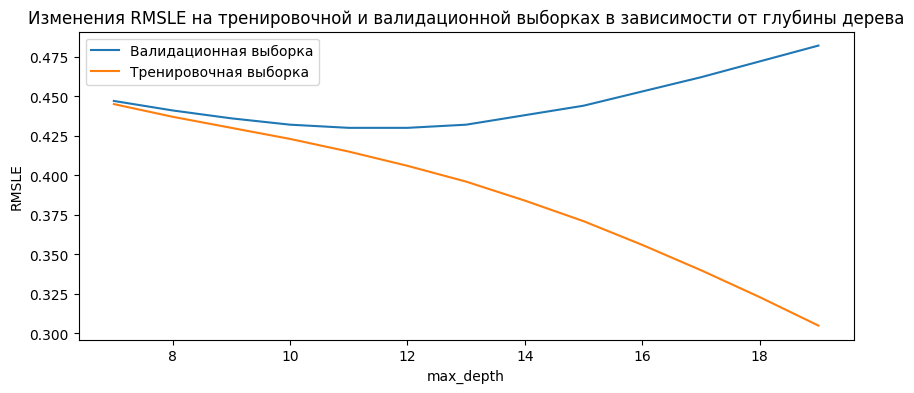

In [56]:
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(max_depths, valid_scores, label='Валидационная выборка')
#Строим линейный график зависимости precision от threshold
ax.plot(max_depths, train_scores, label='Тренировочная выборка')

#Даем графику название и подписи осям
ax.set_title('Изменения RMSLE на тренировочной и валидационной выборках в зависимости от глубины дерева')
ax.set_xlabel('max_depth')
ax.set_ylabel('RMSLE')
ax.legend();

*Из графика видно, что оптимальная глубина дерева равна 12, тк при данной глубине наблюдается минимальное значение RMSLE на обучающей выборке, но при этом ещё не наблюдается переобучение (валидационная кривая ещё не начинает возрастать)*

Посмотрим, чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной

In [57]:
desision_tree = tree.DecisionTreeRegressor(random_state=42, max_depth=12)
desision_tree.fit(X_train_kbest_scaled, y_train_log)
y_train_pred = desision_tree.predict(X_train_kbest_scaled)
y_valid_pred = desision_tree.predict(X_valid_kbest_scaled)
RMSLE_valid = round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3)
RMSLE_train =round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3)
print('RMSLE на валидационной выборке:', RMSLE_valid)
print('RMSLE на тренировочной выборке:', RMSLE_train)

RMSLE на валидационной выборке: 0.43
RMSLE на тренировочной выборке: 0.406


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам. 

### 6.1 Модель случайного леса

Построbv модель случайного леса на обучающей выборке

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. 


In [58]:
rf = ensemble.RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    criterion='squared_error',
    min_samples_leaf=20,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_kbest_scaled, y_train_log)
#Выводим значения метрики 


RandomForestRegressor(max_depth=12, min_samples_leaf=20, n_estimators=200,
                      random_state=42)

In [59]:
y_train_pred = rf.predict(X_train_kbest_scaled)
print('RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred))))
y_valid_pred = rf.predict(X_valid_kbest_scaled)
print('RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred))))

RMSLE на тренировочной выборке: 0.40
RMSLE на валидационной выборке: 0.41


### 6.2. Модель градиентного бустинга
Построим модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке

Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках. 


In [60]:
GB = ensemble.GradientBoostingRegressor(
    learning_rate = 0.5,
    n_estimators = 100,
    max_depth = 6,
    min_samples_split = 30,
    random_state = 42
    )
GB.fit(X_train_kbest_scaled, y_train_log)
y_train_pred = GB.predict(X_train_kbest_scaled)
y_valid_pred = GB.predict(X_valid_kbest_scaled)
print('RMSLE на валидационной выборке:', round(np.sqrt(metrics.mean_squared_error(y_valid_log, y_valid_pred)), 3))
print('RMSLE на тренировочной выборке:', round(np.sqrt(metrics.mean_squared_error(y_train_log, y_train_pred)), 3))

RMSLE на валидационной выборке: 0.393
RMSLE на тренировочной выборке: 0.37


### 6.3 Наилучшая модель
Сравнив значеник метрик, можно сделать вывод, что следующая модель показала наилучший результат (наименьшее значение RMSLE на валидационной выборке):

* Градиентный бустинг над деревьями решений


### 6.4. Коэффициенты значимости
Построим столбчатую диаграмму коэффициентов значимости каждого из факторов для модели граентного бустинга


Text(0.5, 1.0, 'Диаграмма значимости факторов для модели градиентного бустинга')

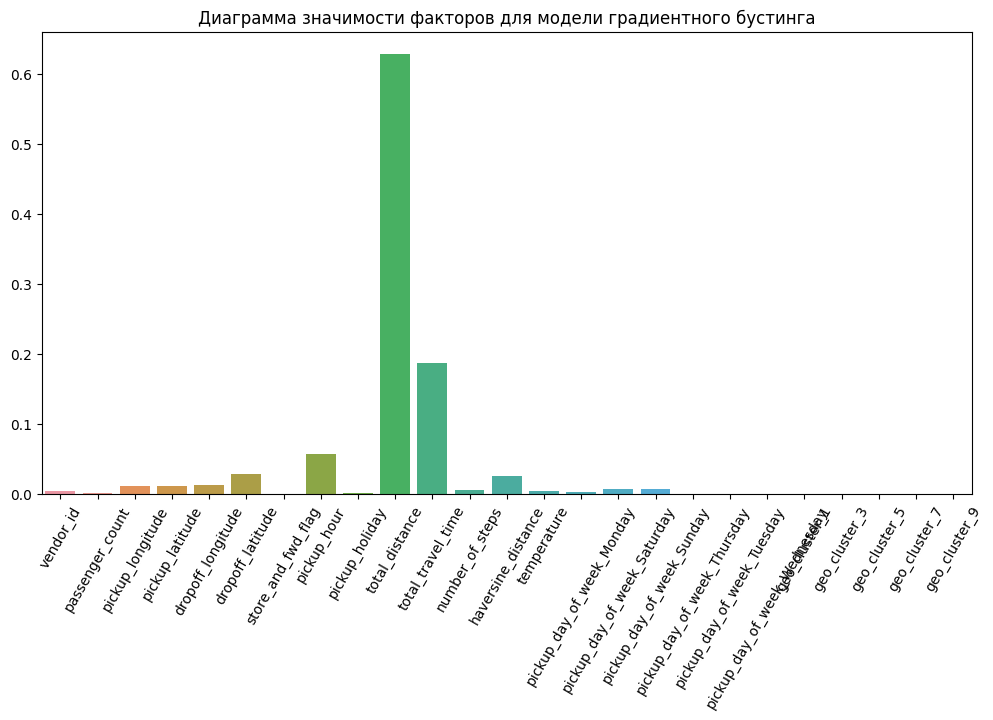

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
importance_coef = GB.feature_importances_
ftr_names = GB.feature_names_in_
fig = sns.barplot(x = ftr_names, y = importance_coef)
fig.xaxis.set_tick_params(rotation=60)
fig.set_title('Диаграмма значимости факторов для модели градиентного бустинга')

Итак, Топ-3 наиболее значимых признака  для предсказания целевого признака в модели градиентного бустинга:


* total_distance:	0.628181
* pickup_hour:	0.057439
* total_travel_time:	0.186373


### 6.5. Рассчет медианной абсолютной ошибки
Для лучшей из построенных моделей рассчитаем медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$
Для этого переведем целевую переменную и предсказания модели из логарифмического масштаба в изначальный по формуле:
$$ y_i = exp(z_i)-1$$


In [62]:
taxi_data['trip_duration_log'] = np.log(taxi_data['trip_duration']+1)
y_valid = np.exp(y_valid_log) - 1
y_valid_pred_exp = np.exp(y_valid_pred) - 1
print('MeAE:', round(metrics.median_absolute_error(y_valid, y_valid_pred_exp), 2) )

MeAE: 109.83


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных. 

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [63]:
test_data = pd.read_csv("data/Project5_test_data.csv")
osrm_data_test = pd.read_csv("data/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [64]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot], 
    axis=1
)
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Shape of data: (625134, 25)


Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Предсказания необходимо перевести  из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$



In [65]:
y_test_predict_log = GB.predict(X_test_scaled)
y_test_predict = np.exp(y_test_predict_log) - 1


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(



После предсказания длительности поездок на тестовой выборке создадим submission-файл в формате csv, отправим его на платформу Kaggle и посмотрим на результирующее значение метрики RMSLE на тестовой выборке.

In [66]:

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)